# Figure 4
## Seasonal distribution of HIPEs grouped by overall magnitude (M) and association to flood characteristics over 1961-2022.  

In [2]:
## ---- Libraries and custom functions --------------------------------------
library(terra)
library(tidyverse)
library(metR)
library(patchwork)
library(ggpubr)
library(elevatr)
setwd("/mnt/CEPH_PROJECTS/HIPEAtMount/HIPEAtMount-WP1")
source("Script/Functions/theme_plot.R")
source("Script/Functions/Ranking_functions.R")

sf_use_s2(FALSE)
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 200)

terra 1.8.60

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks terra::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘metR’


The following object is masked from ‘package:purrr’:

    cross



Attaching package: ‘patchwork’


The following object is masked from ‘package:terra’:

    area



Attaching package: ‘ggpubr’


The following object is masked from ‘package:terra’:

    rotate


elevatr v0.99.0 NOTE: Version 0.99.0 of 'elevatr' uses 'sf' and 'terra'.  Use 
of the 'sp', 'raster', and underlying 'rgdal' p

In [3]:
## ---- Borders & geographic context ----------------------------------------
# Getting Alpine and neighboring borders
borders <- giscoR::gisco_get_countries(country = c(
  "Italy","Switzerland","France","Austria","Slovenia",
  "Germany","Croatia","Bosnia"
), resolution = "03")

# Alpine convention borders
borders_convention <- read_sf("Data/Borders/Alpine_Convention_Perimeter_2018_v2/Alpine_Convention_Perimeter_2018_v2.shp") %>%
  st_transform(crs = st_crs(borders)) %>%
  st_make_valid()

# HISTALP borders
HISTALP_borders <- read_sf("Data/Borders/Shape_CRSM/Shape_CRSM.shp") %>%
  st_transform(crs = st_crs(borders)) %>%
  st_make_valid()

# Intersecting HISTALP with Alpine convention borders
GAR_HISTALP_intersect <- st_intersection(borders_convention, HISTALP_borders) %>% 
  dplyr::select(Id.1) %>% 
  dplyr::rename(Regions = Id.1) %>%
  mutate(
    Regions = ifelse(Regions == 0, "Southwest", Regions),
    Regions = ifelse(Regions == 1, "Northwest", Regions),
    Regions = ifelse(Regions == 2, "Northeast", Regions),
    Regions = ifelse(Regions == 3, "Southeast", Regions)
  )

# Alpine extent
sample_4_extent <- rast("Data/APGD/harmonised/RapdD_al05_19710100_harm.nc")[[1]]
extent <- ext(sample_4_extent)

although coordinates are longitude/latitude, st_intersection assumes that they
are planar

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Mosaicing & Projecting

Note: Elevation units are in meters.



In [4]:
# PREPARING HANZE DATABASE-------------------------------------------------------------------------

HANZE <- read_csv("Data/HANZE/HANZE_events.csv") 
HANZE_2021db_eu <- read_sf("Data/HANZE/HANZE_floods_regions_2021/HANZE_floods_regions_2021.shp") 

HANZE_2021db_alps <- HANZE_2021db_eu %>%
  st_transform(st_crs(borders_convention)) %>%
  st_intersection(borders_convention) %>%
  select(ID,Country,Year,Type,Region2021,Area,Fatalities,LossesEuro,Cause,
         Start_D,Start_M,Start_Y,End_D,End_M,End_Y) %>%
  filter(Start_Y >= 1961) %>%
  unite(c(Start_D,Start_M,Start_Y), col = "Flood_Start_date" ,sep = "-",remove = T) %>%
  unite(c(End_D,End_M,End_Y), col = "Flood_End_date" ,sep = "-",remove = T) %>%
  mutate(Flood_Start_date = dmy(Flood_Start_date),
         Flood_End_date = dmy(Flood_End_date)) 

# Exploring the database  
HANZE_2021db_alps_df <- st_drop_geometry(HANZE_2021db_alps)

annual_floods_fatalities_alpine <- HANZE_2021db_alps_df %>% 
  filter(Type != "Coastal") %>%
  mutate(Year = as.numeric(Year))%>%
  group_by(Year) %>%
  summarise(N_floods = length(ID),
            Fatalities = sum(Fatalities),
            ) %>%
  complete(
    Year = 1961:2020,
    fill = list(N_floods = 0,
                Fatalities = 0)
  ) 

Rows: 2521 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (11): Country code, Country name, Type, Flood source, Regions affected ...
dbl   (7): ID, Year, Area flooded, Fatalities, Persons affected, Losses (nom...
date  (2): Start date, End date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
although coordinates are longitude/latitude, st_intersection assumes that they
are planar

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


In [5]:
# PREPARAING HIPES RANKING ------------------------------------------------
HIPEs <- read_csv("Output/Data/2_ranking_databases/ACPD_complete_ranking/ACPD_HIPE_Ranking_1961-2022_multiday.csv")

# JOINING THE TWO DBS ---------------------------------------------------------
library(dplyr)
library(lubridate)

# Time window after precipitation (in days)
window_days <- 5  # main post-precipitation window

# Safety: ensure HANZE dates are Date
HANZE_2021db_alps_df <- HANZE_2021db_alps_df %>%
  mutate(
    Flood_Start_date = as_date(Flood_Start_date),
    Flood_End_date   = as_date(Flood_End_date)
  )

# 1) Cross HIPEs with HANZE by temporal logic
crossed_data <- HIPEs %>%
  # Cartesian join (explicit) so we can filter by date conditions
  left_join(HANZE_2021db_alps_df, by = character()) %>%
  filter(
    # Precipitation window must not end before the flood ends
    Start_date <= Flood_End_date &
    (
      # (a) Flood starts within [Start_date, End_date + window_days]
      (Flood_Start_date >= Start_date &
       Flood_Start_date <= (End_date + days(window_days))) |
      # (b) Flood is reported 1–2 days before Start_date (lead/lag tolerance)
      (Flood_Start_date >= (Start_date - days(2)) &
       Flood_Start_date <= Start_date)
    )
  ) %>%
  select(
    Event, A, m, M, Start_date, End_date, Duration,
    ID, Country, Year, Type, Region2021, Area, Fatalities, LossesEuro, Cause,
    Flood_Start_date, Flood_End_date
  ) %>%
  distinct()

# Quick check
# head(crossed_data)

# 2) Complete back to the full HIPEs table
#    Keep ALL HIPEs even if there is NO matching flood (NAs for flood fields).
completed_HIPES_floods <- HIPEs %>%
  left_join(
    crossed_data,
    by = c("Event", "A", "m", "M", "Start_date", "End_date", "Duration")
  ) %>%
  mutate(
    ID              = replace_na(ID, NA),
    Country         = replace_na(Country, NA),
    Year            = replace_na(Year, NA),
    Type            = replace_na(Type, NA),
    Region2021      = replace_na(Region2021, NA),
    Area            = replace_na(Area, NA),
    Fatalities      = replace_na(Fatalities, NA),
    LossesEuro      = replace_na(LossesEuro, NA),
    Cause           = replace_na(Cause, NA),
    Flood_Start_date= replace_na(Flood_Start_date, NA),
    Flood_End_date  = replace_na(Flood_End_date, NA)
  )
# transboundary yes-no, number of countries afected, regions afected, Fatalities, Tipus River, Flood, binari flood yes/NO
completed_HIPES_floods %>% head


Rows: 1010 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (6): Event, A, m, m_log, M, Duration
date (2): Start_date, End_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Using `by = character()` to perform a cross join was deprecated in dplyr 1.1.0.
ℹ Please use `cross_join()` instead.”


Event,A,m,m_log,M,Start_date,End_date,Duration,ID,Country,Year,Type,Region2021,Area,Fatalities,LossesEuro,Cause,Flood_Start_date,Flood_End_date
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<date>,<date>
937,0.10193898,65.70453,9.381368,0.9563271,2018-10-27,2018-10-29,3,2910,Austria,2018,River,AT212;AT321,NA,0,339054210,Heavy rainfall,2018-10-28,2018-10-30
937,0.10193898,65.70453,9.381368,0.9563271,2018-10-27,2018-10-29,3,2172,Italy,2018,River/Coastal,ITC34;ITC46;ITC47;ITH10;ITH20;ITH33;ITH34;ITH35;ITH36;ITH42;ITH52;ITI11;ITI45,39,3,NA,Heavy rainfall up to 716 mm in 4 days and storm surge in Venice,2018-10-27,2018-10-31
870,0.05025663,66.69736,12.917562,0.6491931,2014-11-02,2014-11-06,5,996,Italy,2014,River,ITC32;ITC33;ITC34;ITC41;ITC46;ITC49;ITC4A;ITC4C;ITC4D,NA,3,138209985,"Heavy rainfall (2 waves), up to 231 mm in 24 h",2014-11-09,2014-11-16
622,0.05638723,111.58379,10.488301,0.5914062,2000-10-13,2000-10-15,3,944,Italy,2000,River,ITC11;ITC12;ITC14;ITC18;ITC20;ITC48;ITC49;ITC4A;ITC4B;ITH10;ITH51;ITH52;ITH54,NA,34,3637543882,Heavy rainfall up to 740 mm in 4 days,2000-10-13,2000-10-16
622,0.05638723,111.58379,10.488301,0.5914062,2000-10-13,2000-10-15,3,1465,Switzerland,2000,River,CH012;CH070,NA,3,672038992,Heavy rainfall,2000-10-13,2000-10-16
86,0.05218135,90.50554,11.317847,0.5905805,1966-11-02,1966-11-05,4,2048,Austria,1966,River,AT211;AT212;AT213;AT333,NA,14,151066684,Heavy rainfall up to 258 mm in 24 h and snowmelt,1966-11-03,1966-11-05


In [6]:
# Compute the statistics with regards to the probability of occurrence 

statistics_HIPES_floods <- completed_HIPES_floods %>%
  group_by(Event,A,m,M,Start_date,End_date) %>%
  summarise(Flood= ifelse(!is.na(Flood_Start_date),1,0),
            Fatalities_Fl = sum(Fatalities, na.rm = T),
            Transboundary_Fl = ifelse(length(Country) > 1, 1,0),
            Countries_Fl = length(Country),
            Regions_Fl = sum(str_count(Region2021, ";") + 1),
            Regions_Fl = ifelse(is.na(Regions_Fl),0,Regions_Fl)) %>%
  ungroup()%>%
  distinct_all() %>%
  arrange(desc(M)) %>%
  left_join(select(completed_HIPES_floods, Event, Type)) %>%
  distinct_all() %>%
  mutate(M_group = (dense_rank(desc(M)) - 1) %/% 20 + 1) %>%
  # Assign the same group to all rows with the same Event
  group_by(Event) %>%
  mutate(M_group = first(M_group)) %>%
  ungroup() %>%
  mutate(River_flood = ifelse(str_starts(Type,"River"),1,0),
         Flash_flood = ifelse(str_starts(Type,"Flash"),1,0))
  
last_statistics_HIPES_floods <- statistics_HIPES_floods %>% 
  select(Event, Start_date, End_date, Flood, River_flood, Flash_flood, Fatalities_Fl,Transboundary_Fl)  %>%
  filter(!(River_flood == 0 & Flash_flood == 0)) %>% 
  group_by(Event, Start_date, End_date) %>%
  summarize(
    Flood = max(Flood, na.rm = TRUE),
    River_flood = max(River_flood, na.rm = TRUE),
    Flash_flood = max(Flash_flood, na.rm = TRUE),
    Fatalities_Fl = max(Fatalities_Fl, na.rm = TRUE),
    Transboundary_Fl = max(Transboundary_Fl, na.rm = TRUE)
  ) %>%
  ungroup() %>%
  inner_join(select(statistics_HIPES_floods, Event, M, M_group), by = c("Event")) %>%
  arrange(desc(M)) %>%
  distinct_all() 

statistics_magnitude_groups_ratio <- last_statistics_HIPES_floods %>%
  # distinct(Event, .keep_all = T) %>%
  mutate(season = season(Start_date)) %>%
  group_by(M_group, season) %>%
  summarise(ratio_flood = sum(Flood)/20,
            ratio_fatalitie = sum(Fatalities_Fl>0)/20,
            ratio_transboundary = sum(Transboundary_Fl > 0)/20,
            ratio_river_flood = sum(River_flood,na.rm=T)/20,
            ratio_flash_flood = sum(Flash_flood,na.rm = T)/20) %>%
  pivot_longer(ratio_flood:ratio_flash_flood)


Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Event', 'A', 'm', 'M', 'Start_date',
'End_date'. You can override using the `.groups` argument.
Joining with `by = join_by(Event)`
`summarise()` has grouped output by 'Event', 'Start_date'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'M_group'. You can override using the
`.groups` argument.


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


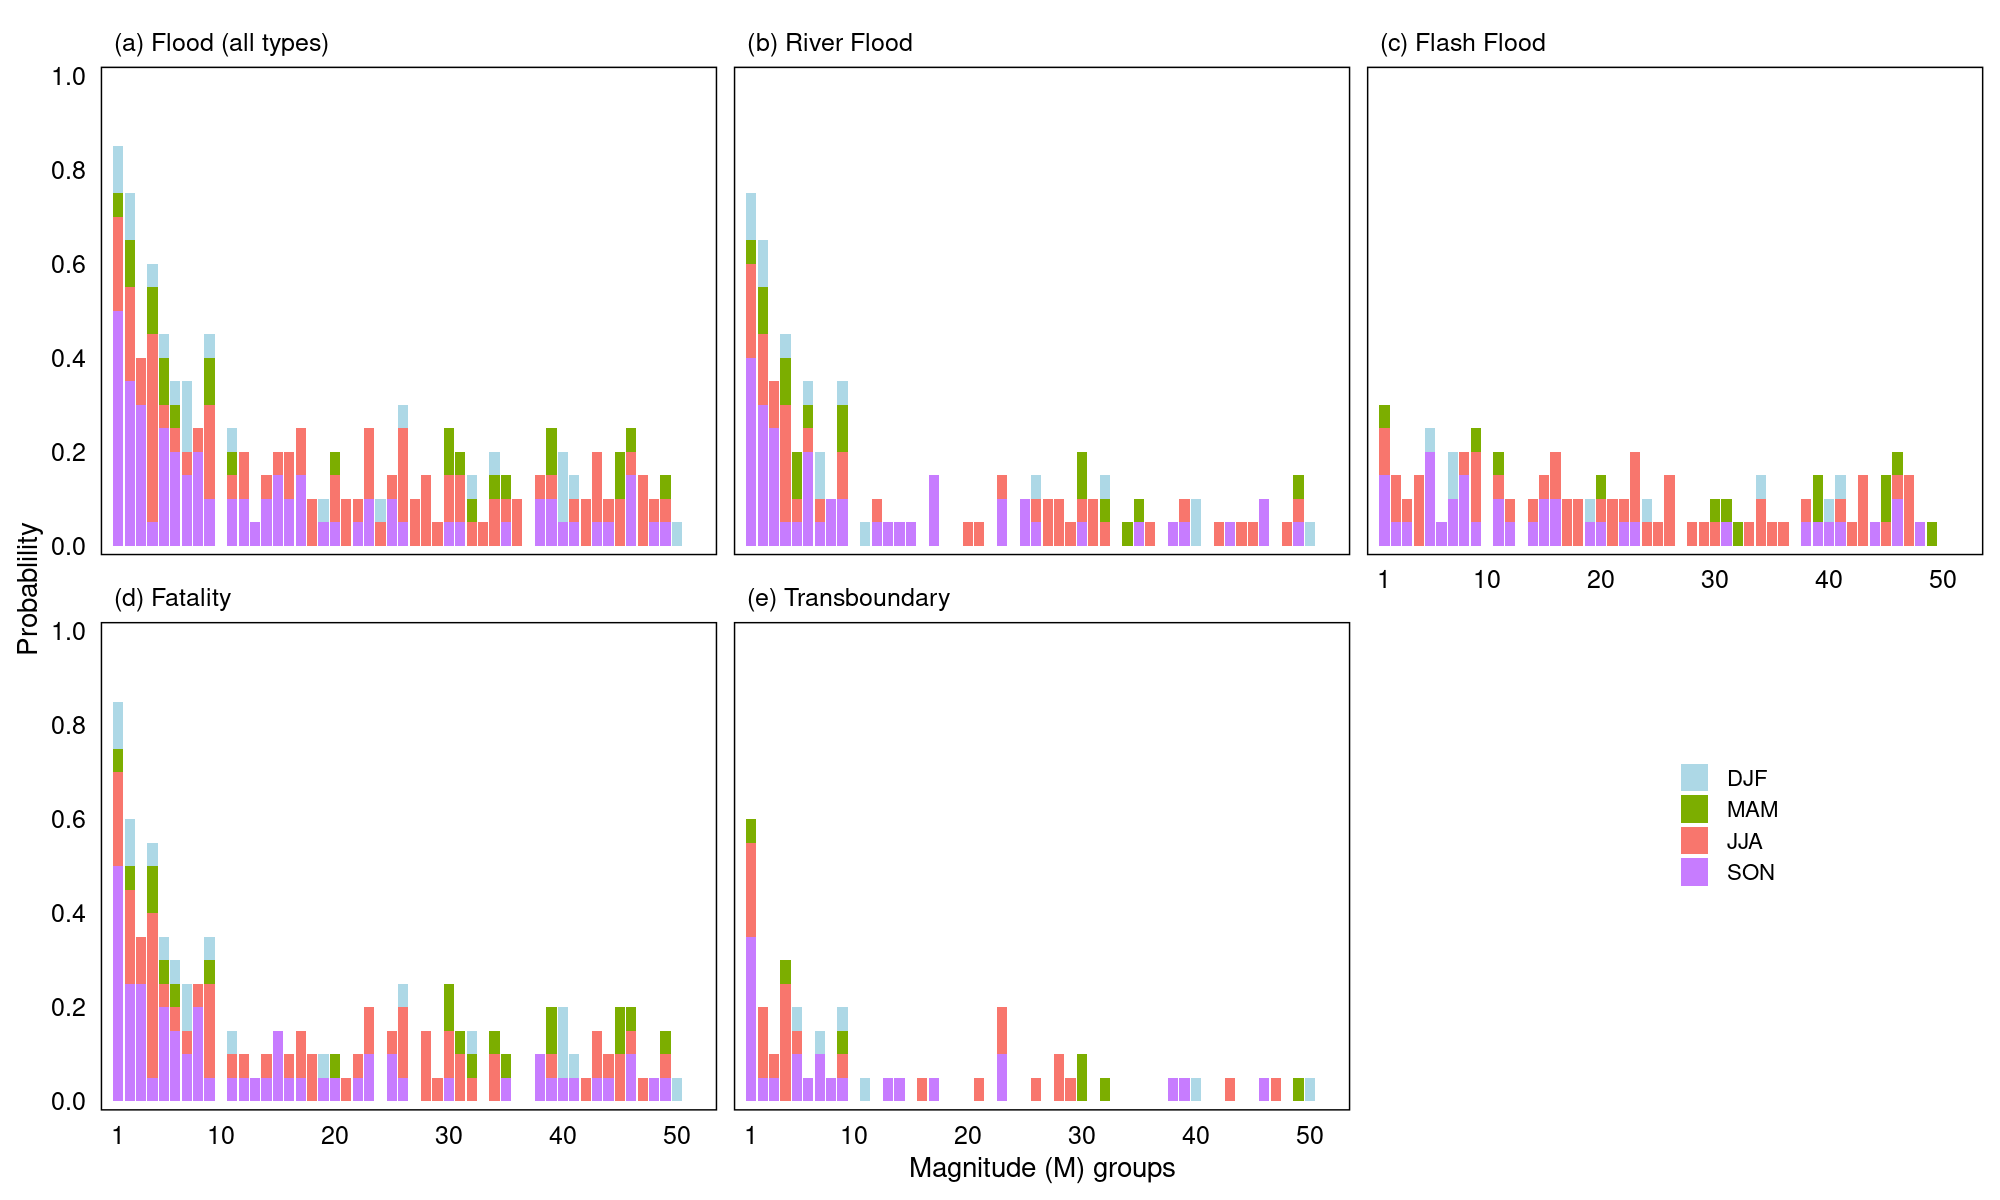

In [7]:
# Plot 
statistics_magnitude_groups_ratio$name <- factor(
  statistics_magnitude_groups_ratio$name,
  levels = c("ratio_flood", "ratio_river_flood", "ratio_flash_flood", "ratio_fatalitie", "ratio_transboundary")
)

library(ggpubr)
ggplot(data = statistics_magnitude_groups_ratio, aes(x = M_group, y = value, fill = season))+
  geom_bar(stat = "identity",show.legend = T) +
  scale_x_continuous(breaks = c(1,seq(10,100,10)), limits = c(0,53),expand = c(0.01,0.01))+
  scale_y_continuous(expand = c(0.015,0.015)) +
  scale_fill_manual(values = c("lightblue","#7CAE00","#F8766D","#C77CFF")) +
  # stat_smooth(method = "nls", formula = y ~ a * exp(-S * x), 
  #             method.args = list(start = list(a = 78, S = 0.02)), se = FALSE, #starting values obtained from fit above
  #             color = "dark red",show.legend = F) +
  labs(#subtitle = "(c)",
       x = "Magnitude (M) groups",
       y = "Probablility") +
  scale_y_continuous(breaks = seq(0,1,0.2), limits = c(0,1), expand = c(0.01,0.01)) +
  facet_wrap(~name,nrow = 2, labeller = labeller(name = c("ratio_flood" = "(a) Flood (all types)",
                                                 "ratio_fatalitie" = "(d) Fatality",
                                                 "ratio_transboundary" = "(e) Transboundary",
                                                 "ratio_river_flood" = "(b) River Flood",
                                                 "ratio_flash_flood" = "(c) Flash Flood"))) + # Add (a) and (b)
  theme_4paper2 +
  theme(legend.title = element_blank(),
        panel.grid = element_blank(),
        plot.subtitle = element_text(size = 10),
        axis.text = element_text(size = 9,color = "black"),
        axis.title = element_text(size = 10),
        legend.position = c(0.9, 0.35),  # Position in the upper-right corner
        legend.key.size = unit(0.4,"cm"),
        legend.justification = c(1, 1), # Align legend to the top-right
        legend.box = "vertical",
        # axis.title.y = element_blank(),
        legend.background = element_rect(fill = "transparent",color = "transparent"))     